In [1]:
import os
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

from sklearn.preprocessing import StandardScaler

import umap
import umap.plot

import warnings
warnings.filterwarnings('ignore')

c:\Users\이정진\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 파일경로 설정

In [2]:
data_path = os.path.join(os.getcwd(),'data')
files = os.listdir(data_path)[:-1]

# aisles = pd.read_csv(os.path.join(data_path,files[0]), engine='pyarrow') # (134, 2)
# departments = pd.read_csv(os.path.join(data_path,files[1]), engine='pyarrow') # (21, 2)
# orders = pd.read_csv(os.path.join(data_path,files[2]), engine='pyarrow') # (3421083, 7)
# orders_products_prior = pd.read_csv(os.path.join(data_path,files[3]),engine='pyarrow') # (32434489, 4)
# orders_products_train = pd.read_csv(os.path.join(data_path,files[4]),engine='pyarrow') # (1384617, 4)
# products = pd.read_csv(os.path.join(data_path,files[5]),engine='pyarrow') # (49688, 4)

데이터 설명
* aisles - 통로(코너, 냉동 department의 어류 이런 세부종류?) aisleid, aisle
* departments - department종류(냉동식품 등)  department id, department
* orders - userid, eval_set(prior, train, test), 주문번호, 주문요일?, 주문시간대, since prior order
* order_products_* - orderid, 상품id, add to cart order, reorderd(재주문 여부, none은 0으로)
* products - 상품id, 상품명, aisleid, departmentid

# 분석용 전체 데이터 생성

In [3]:
# prior = orders[orders['eval_set']== 'prior']
# train = orders[orders['eval_set'] == 'train']
# test = orders[orders['eval_set'] == 'test']
# del train['eval_set'], test['eval_set'], prior['eval_set']

# temp = orders_products_train.set_index('order_id')
# orders_train = pd.merge(temp, train, on='order_id')

# temp = orders_products_prior.set_index('order_id')
# orders_prior = pd.merge(temp, prior, on='order_id')

# total_orders = pd.concat([orders_prior, orders_train])
# temp = pd.merge(total_orders,products , on='product_id')
# temp = pd.merge(temp, aisles, on='aisle_id')
# temp = pd.merge(temp, departments, on='department_id')

# total_orders.to_parquet('total_orders.parquet', index=False)

# 분석

In [3]:
total_orders = pd.read_parquet('total_orders.parquet',engine='fastparquet')

In [5]:
total_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,26,33120,5,0,153404,2,0,16,7.0,Organic Egg Whites,86,16,eggs,dairy eggs
2,120,33120,13,0,23750,11,6,8,10.0,Organic Egg Whites,86,16,eggs,dairy eggs
3,327,33120,5,1,58707,21,6,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
4,390,33120,28,1,166654,48,0,12,9.0,Organic Egg Whites,86,16,eggs,dairy eggs


## 기본 분석

## 군집화
재구매율을 통해 고객 군집화를 통한 고객 segmentation

### order_id 기준(한 사람이 주문해도 다른 주문으로 처리)

In [ ]:
# 전처리 코드 모음
temp=total_orders.groupby(['user_id']).agg({'reordered':'sum', 'user_id':'count'}).rename(columns={'user_id':'count'}).reset_index()
temp['reorder_ratio'] = temp['reordered'] / temp['count']
temp['class'] = pd.qcut(temp['reorder_ratio'],[0,0.25,0.5,0.75,1], labels=[4,3,2,1])
order_list = total_orders.groupby(['user_id']).product_name.apply(list).reset_index(name='order_list').set_index('user_id')['order_list']
tab1 = pd.crosstab(total_orders['user_id'], total_orders['aisle'])
label_table = temp[['user_id','class']]
label1 = pd.merge(tab1,label_table, on='user_id')['class']


In [4]:
order_list = total_orders.groupby(['user_id']).product_id.apply(list).reset_index(name='order_list').set_index('user_id')['order_list']

In [6]:
tab1 = pd.crosstab(total_orders['user_id'], total_orders['aisle'])
b = pd.merge(tab1, order_list, on='user_id')
b

: 

: 

In [6]:
temp=total_orders.groupby(['user_id']).agg({'reordered':'sum', 'user_id':'count'}).rename(columns={'user_id':'count'}).reset_index()
temp['reorder_ratio'] = temp['reordered'] / temp['count']
temp.head()


,user_id,reordered,count,reorder_ratio
0,1,51,70,0.728571
1,2,105,226,0.464602
2,3,55,88,0.625000
3,4,1,18,0.055556
4,5,18,46,0.391304


<Axes: xlabel='reorder_ratio', ylabel='Count'>

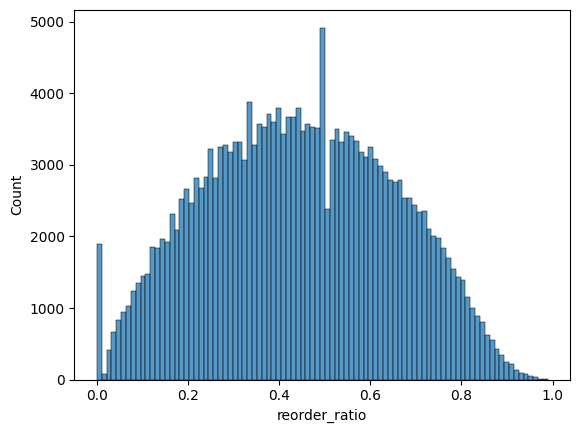

In [6]:
sns.histplot(temp['reorder_ratio'])

In [9]:
temp['class'] = pd.qcut(temp['reorder_ratio'],[0,0.25,0.5,0.75,1], labels=[4,3,2,1])

<Axes: >

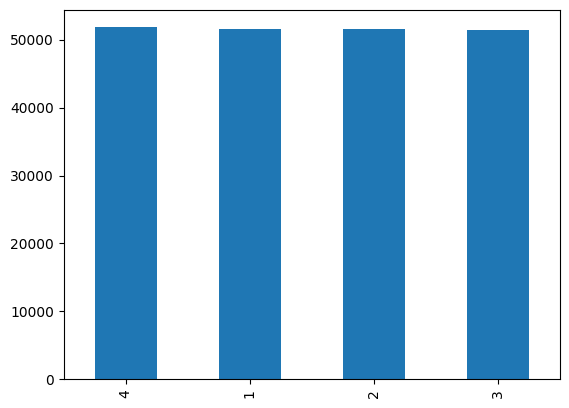

In [7]:
# 재구매율 기준 
temp['class'].value_counts().plot(kind='bar')

#### aisle(중분류 기준)

In [ ]:
tab1 = pd.crosstab(total_orders['user_id'], total_orders['aisle'])
label_table = temp[['user_id','class']]
label1 = pd.merge(tab1,label_table, on='user_id')['class']

KeyError: "['class'] not in index"

#### department(대분류 기준)

In [12]:
tab2 = pd.crosstab(total_orders['user_id'], total_orders['department'])
label_table = temp[['user_id','class']]
label2 = pd.merge(tab2,label_table, on='user_id')['class']

### Umap 적용

In [13]:
scaled_tab1 = StandardScaler().fit_transform(tab1)
embedding1 = umap.UMAP(random_state=42).fit(scaled_tab1) 
                    #   n_neighbors=10,
                    #   min_dist=0.2,
                    #   metric='correlation'# 인자 공부....?

<Axes: >

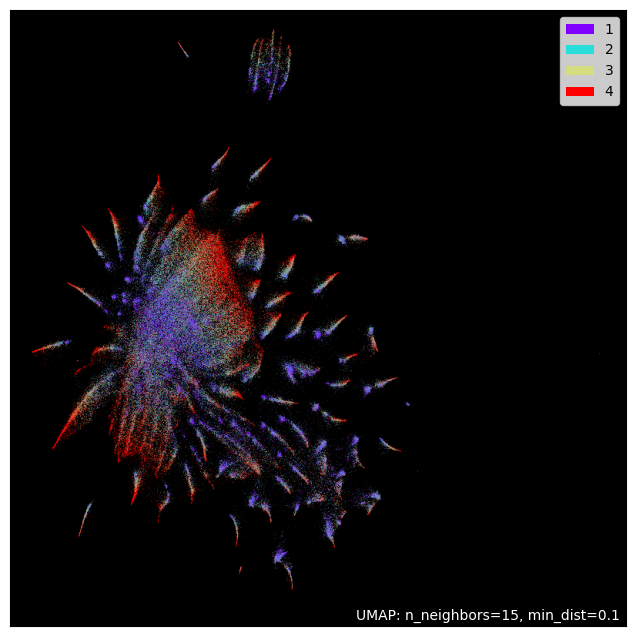

In [14]:
umap.plot.points(embedding1, label1, theme='fire')
# class, user_id, order_id 구매목록 뜨게하기?

In [15]:
scaled_tab2 = StandardScaler().fit_transform(tab2)
embedding2 = umap.UMAP(random_state=42).fit(scaled_tab2) 

<Axes: >

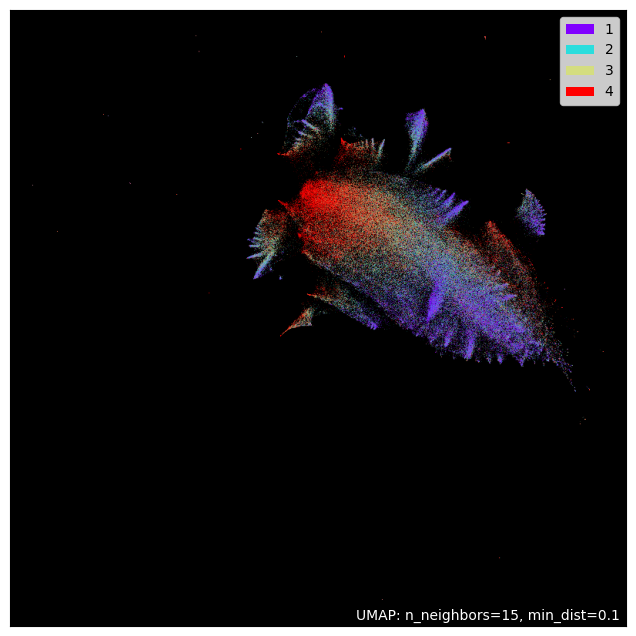

In [16]:
umap.plot.points(embedding2, label2, theme='fire')

### order_id 기준(한 사람이 주문해도 다른 주문으로 처리)

In [17]:
temp=total_orders.groupby(['order_id']).agg({'reordered':'sum', 'user_id':'count'}).rename(columns={'user_id':'count'}).reset_index()
temp['reorder_ratio'] = temp['reordered'] / temp['count']
temp.head()


,order_id,reordered,count,reorder_ratio
0,1,4,8,0.500000
1,2,6,9,0.666667
2,3,8,8,1.000000
3,4,12,13,0.923077
4,5,21,26,0.807692


<Axes: xlabel='reorder_ratio', ylabel='Count'>

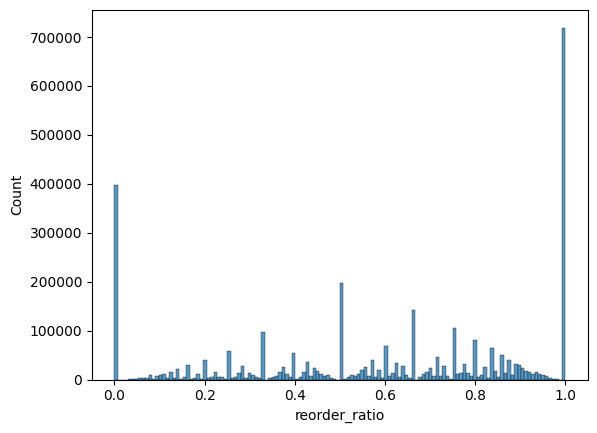

In [18]:
sns.histplot(temp['reorder_ratio'])

<Axes: >

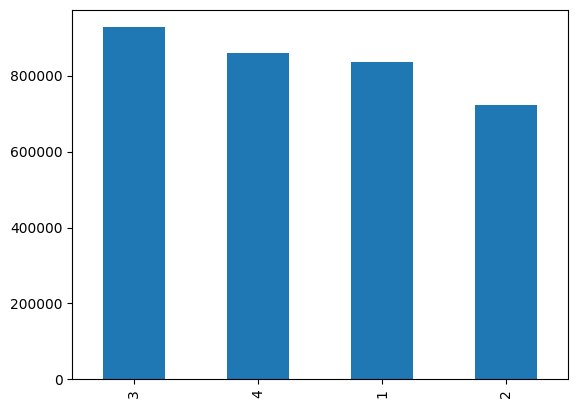

In [19]:
# 재구매율 기준 
temp['class'] = pd.qcut(temp['reorder_ratio'],[0,0.25,0.5,0.75,1], labels=[4,3,2,1])
temp['class'].value_counts().plot(kind='bar')

#### aisle(중분류 기준)

In [20]:
tab1 = pd.crosstab(total_orders['order_id'], total_orders['aisle'])
label_table = temp[['order_id','class']]
label1 = pd.merge(tab1,label_table, on='order_id')['class']

: 

: 

#### department(대분류 기준)

In [ ]:
tab2 = pd.crosstab(total_orders['order_id'], total_orders['department'])
label_table = temp[['order_id','class']]
label2 = pd.merge(tab2,label_table, on='order_id')['class']

### Umap 적용

In [ ]:
scaled_tab1 = StandardScaler().fit_transform(tab1)
embedding1 = umap.UMAP(random_state=42).fit(scaled_tab1) 
                    #   n_neighbors=10,
                    #   min_dist=0.2,
                    #   metric='correlation'# 인자 공부....?

In [ ]:
umap.plot.points(embedding1, label1, theme='fire')

In [ ]:
scaled_tab2 = StandardScaler().fit_transform(tab2)
embedding2 = umap.UMAP(random_state=42).fit(scaled_tab2) 

In [ ]:
umap.plot.points(embedding2, label2, theme='fire')

In [ ]:
labels = HDBSCAN(
    min_samples=100,
    min_cluster_size=1000
).fit_predict(X_reduced) # 또는 임베딩을 군집화해서 라벨링

mapper = UMAP(
      random_state=42,
      metric='euclidean',
      n_components=2,
      n_neighbors= 24,
      min_dist=0.1).fit(X.drop('label', axis=1))